# Notes

A quick analysis of the data on water reservoirs in Andvalucia. Note: I'm not a water or climate researcher.
Think of these as mostly descriptive statistics of the dataset. Please do not share any 
assumption-driven analysis in here. I guess I can't stop you, but all I can say is that these are speculative, and
thus you cannot really know that they work well.

In [1]:
import pandas as pd
import parse as p
import os
import altair as alt
from statsmodels import api as sm
import statsmodels.formula.api as smf

import importlib

import os
os.chdir("..")

# Rainfall

The raw data provides the cumulative rain in the
water-year (starting October 1) compared to a historic average since 1970.
My guess is that this format can be helpful if we assume that there's some
year-long offsetting, e.g. a large amount of early-year rain is likely followed
by less rain later on.

In [2]:
importlib.reload(p)

folder_output = './data/output'
filenames_all = sorted(os.listdir(folder_output))
filenames = [f for f in filenames_all if p.filter_monthly(f)]

df_all = p.get_full_df(filenames)
df_all = p.correct_issues(df_all)
df_all = p.add_cols(df_all)

# Set current directory to the folder where the script is located

In [29]:
cols_reset = ['rainfallsince', 'avgrainfall1971_2000']

# Set these columns to zero on the first climatic month
# This looks like a data error, but need to investigate
df_all.loc[df_all['month_climatic'] == 1, cols_reset] = 0

cols = ['rainfallsince', 'avgrainfall1971_2000']

agg = (df_all
      .query('~ is_month_start')
      .groupby(['date', 'province'])[cols]
      .sum())

agg['relative_rainfall'] = agg[cols[0]] / agg[cols[1]]
top_code = 2
agg.loc[agg.relative_rainfall > top_code, 'relative_rainfall'] = top_code
agg.loc[agg.relative_rainfall < 0, 'relative_rainfall'] = 0

title = f'Rainfall compared to historical average during climate-year (top-coded at {top_code*100}%)'
chart = alt.Chart(agg.reset_index()).mark_line().encode(
    x=alt.X('date'),
    y=alt.Y('relative_rainfall', axis=alt.Axis(format='%'), title=None),
    color='province'
).properties(
    width=600,
    height=300,
    title=title
)
rule = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(color='black').encode(y='y')
chart = rule + chart

chart

alt.LayerChart(...)

In [35]:
pd.set_option('display.precision', 2)

agg = agg.reset_index()
agg['month'] = agg.date.dt.month
agg.query('month==9').groupby(['date', 'province']).relative_rainfall.mean().unstack(1)

province,almeria,cadiz,cordoba,granada,huelva,jaen,malaga,sevilla
date,,,,,,,,
2012-09-01,0.46,0.49,0.35,0.43,0.58,0.31,0.58,0.36
2013-09-01,0.69,1.12,1.44,1.51,1.31,1.86,1.24,1.35
2014-09-01,0.25,0.63,0.83,0.79,0.73,0.92,0.44,0.85
2015-09-01,0.49,0.72,0.73,0.74,0.90,0.75,0.65,0.77
2016-09-01,0.39,0.64,0.96,0.69,1.14,0.98,0.61,0.99
2017-09-01,0.87,0.79,0.95,0.76,1.08,0.76,0.89,1.04
2018-09-01,0.58,0.98,1.07,1.26,1.16,1.33,0.83,1.10
2019-09-01,0.46,0.57,0.63,0.77,0.64,0.76,0.80,0.71
2020-09-01,0.61,0.61,0.92,0.90,0.87,1.00,0.79,0.89


In [38]:
means = agg.query('month==9').groupby(['date']).relative_rainfall.mean()
means

date
2012-09-01    0.45
2013-09-01    1.31
2014-09-01    0.68
2015-09-01    0.72
2016-09-01    0.80
2017-09-01    0.89
2018-09-01    1.04
2019-09-01    0.67
2020-09-01    0.82
2021-09-01    0.79
2022-09-01    0.73
2023-09-01    0.67
Name: relative_rainfall, dtype: float64

In [39]:
means[means.index > '2019-01-01'].mean()

0.7363505820104999

### Summary
 
Rain has been below historical averages after the 2018 water-year.

# Storage over time

We see the generally declining trend, especially since 2018. 
The large amount of rain in early 2018 goes along (and probably caused)
the increased storage. Since then, storage levels have declined relatively consistently,
from an average of 60% in 2018 towards 20% at the beginning of 2024.

In [7]:
cols = ['rainfallsince', 'stored_hm3', 'capacity_hm3']
agg = df_all.groupby(['date', 'province'])[cols].sum()
agg['share_storage'] = agg.stored_hm3 / agg.capacity_hm3

chart = alt.Chart(agg.reset_index()).mark_line().encode(
    x=alt.X('date'),
    y=alt.Y('share_storage', axis=alt.Axis(format='%'), title=None),
    color='province',
).properties(
    width=600,
    height=300
)

title = 'Fill share over time'
chart = chart.properties(title=title)

# chart.save('images/fill_over_time.png')

chart

alt.Chart(...)

# Explaining fill share with rainfall

Rainfall throughout the year is a strong predictor of the fill share.
This allows answering a counterfactual question: Was the relative drought responsible for the low fill share?

Warning: This a very quick and unvalidated analysis, definitely not meant to be shared. More meant as 
a discussion starter.

The counterfactual experiment is: Instead of the actually observed rain, assume that every year observed the
historical average amount of rain. This is a bit optimistic even for a "no-drought" scenario, because even non-drought years will have variation in rainfall, and it's likely that keeping reservoirs full is harder with such variation. But it feels
like it should be a decent first estimate.

The model does a reasonable job reproducing the real pattern in the long run, but it's more muted than the true effects, e.g. after the huge rains of 2018, the bounce-back in 
storage rates from the model is only a third of true effect. More to do!

With all these caveats out of the way: **Based on this model, the drought can explain the decline in fill rates.** 
If we simulate under the assumption of rainfall following historical averages,
the reservoirs would not deplete, and even slightly increase towards a 60% fill rate in 2024.

In [40]:
data_yearly = df_all.groupby(['year_climatic', 'province','reservoir']).last()
data_yearly['share_storage'] = data_yearly.stored_hm3 / data_yearly.capacity_hm3
group_vars = ['province', 'reservoir']
data_yearly['share_storage_lag'] = data_yearly.groupby(group_vars)['share_storage'].shift(1)
data_yearly['rel_rainfall_compare'] = data_yearly.rainfallsince / data_yearly.avgrainfall1971_2000

In [41]:
form = 'share_storage ~ rel_rainfall_compare + share_storage_lag'
model = smf.ols(formula=form, data=data_yearly.reset_index()).fit()

def get_predict(rel_rainfall_compare):
    df_predict = data_yearly.copy()
    years = df_predict.year.unique()
    df_predict['rel_rainfall_compare'] = rel_rainfall_compare

    for year in years[1:]:
        df_year = df_predict.query('year == @year').copy()
        predicts = model.predict(df_year.reset_index())
        df_year['share_storage'] = predicts.values
        df_predict.loc[df_predict.year == year, 'share_storage'] = df_year.share_storage.values
        df_predict['share_storage_lag'] = df_predict.groupby(group_vars)['share_storage'].shift(1)
    return df_predict

df_res = pd.DataFrame()
df_res['current'] = data_yearly.groupby('year')[['share_storage']].mean()
df_res['current_pred'] = get_predict(data_yearly.rel_rainfall_compare).groupby('year')[['share_storage']].mean()
df_res['counterfactual_histavg'] = get_predict(1).groupby('year')[['share_storage']].mean()

# Plot this using altair
res = df_res.reset_index()
res = res.melt(id_vars='year')
res['year'] = res.year.astype(int)
res['value'] = res.value
res['variable'] = res.variable.str.replace('current_pred', 'simulation with actual rain')
res['variable'] = res.variable.str.replace('current', 'actual')
res['variable'] = res.variable.str.replace('counterfactual_histavg', 'simulation with historical avg rain')
res['variable'] = res.variable.str.replace('share storage', 'share storage (%)')

title = 'Share of storage over time, actual vs simulation'
chart = alt.Chart(res).mark_line().encode(
    x=alt.X('year', axis=alt.Axis(format='d')),
    y=alt.Y('value', axis=alt.Axis(format='%'), scale=alt.Scale(domain=[res['value'].min(), res['value'].max()])),
    color='variable',
).properties(
    width=600,
    height=300,
    title=title
)
chart

alt.Chart(...)

In [26]:
# The data for the chart: Average rates
pd.set_option('display.precision', 1)
df_res * 100

,current,current_pred,counterfactual_histavg
year,,,
2012,52.1,52.1,52.1
2013,77.1,66.4,54.3
2014,67.8,58.1,56.0
2015,58.8,51.7,57.2
2016,52.1,50.1,58.4
2017,44.3,49.8,58.8
2018,62.9,55.8,59.4
2019,47.3,48.4,59.9
2020,44.4,47.7,60.3


# What price would achieve neutrality?

If we understand how much the reservoir demand declines over time, and we 
combine it with refilling patterns from rain and the elasticity demand, we can
answer a key economic question: What price would be required so that water demand
is self-sustaining?

Note: This isn't a policy endorsement of this proposal, just a description of a simple
way of understanding the price impact. If the price is not adjusted,
demand pattern is unlikely to change. Reservoir supply is relatively fixed (which would change if one
finds inexpensive ways of reducing water loss), then the only way to prevent drawdown of reservoirs is to add supply, either through desalination plants or by transporting in drinkable water from other regions.

In [17]:
form = 'share_storage_diff ~ rel_rainfall_compare'
data_yearly['share_storage_diff'] = data_yearly.share_storage - data_yearly.share_storage_lag
model_drawdown = smf.ols(formula=form, data=data_yearly.reset_index()).fit()
model_drawdown.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     share_storage_diff   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     343.8
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           5.53e-65
Time:                        16:50:00   Log-Likelihood:                 471.60
No. Observations:                 876   AIC:                            -939.2
Df Residuals:                     874   BIC:                            -929.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.2511      0.013    -18.737      0.000      -0.277      -0.225
rel_rainfall_compare     0.2745      0.015     18.543      0.000       0.245       0.304
==============================================================================
Omnibus:                      117.356   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.489
Skew:                           0.658   Prob(JB):                     3.89e-78
Kurtosis:                       5.834   Cond. No.                         5.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Consumption reduction for neutrality

The intercept of the model gives us the drawdown without rain, which is 25%.

In 2023, rainfall was 54% of the historical average. Let's assume that going forward.

Then this implies that the yearly rain refills 0.54 * 27% = 15%, thus we remain with a 10% reduction every year.

How much would consumption have to decline to get to neutral? By 40% (=10%/25%).

## Elasticity: We assume -0.5
- In Andalucia, it's likely that a majority of use is for agriculture (although possibly not for this reservoir). It looks like agricultural elasticity estimates are quite crop-dependent.
- Let's simplify and take a worst-case analysis, with agricultural elasticity dominating, and being around 0.5.
- This implies that we need roughly a 60% price increase = 30% / (1 / elasticity)

## Price increase required

**With an elasticity of -0.5, and a 40% consumption reduction required, prices would have to increase by 80%.**

# After a rain, what's the time pattern for reservoirs to fill up?

In [21]:
import importlib
importlib.reload(p)
import numpy as np

folder_output = './data/output'
filenames_all = sorted(os.listdir(folder_output))
filenames = [f for f in filenames_all if p.filter_function(f, lambda ds: ds >= "2023_10_01")]
filenames[-3:]

['2024_02_06.csv', '2024_02_07.csv', '2024_02_08.csv']

In [23]:
filenames_all = sorted(os.listdir(folder_output))
filenames = [f for f in filenames_all if p.filter_function(f, lambda ds: ds >= "2023_10_01")]
filenames[-3:]
df_all = p.get_full_df(filenames)
df_all = p.correct_issues(df_all)
df_all = p.add_cols(df_all)

df_all['date_lag'] = df_all.groupby(['province', 'reservoir'])['date'].shift(1)

cols = ['rainfallsince', 'stored_hm3', 'capacity_hm3']
for var in ['rainfallsince', 'stored_hm3']:
    df_all[f'{var}_diff'] = df_all.groupby(['province', 'reservoir'])[var].diff()
    df_all[f'{var}_diff_0'] = df_all[f'{var}_diff']
    for lags in range(1, 10):
        df_all[f'{var}_diff_{lags}'] = df_all.groupby(['province', 'reservoir'])[f'{var}_diff'].shift(lags)
        
df_all['bad_data'] = df_all.rainfallsince_diff_0 < -10
df_all['bad_data_for_year'] = df_all.groupby(['province', 'reservoir', 'year_climatic'])['bad_data'].transform('any')
df_all['problem_month'] = df_all.month.isin([1, 10, 11, 12])
df_all['bad_data_and_month'] = df_all.bad_data & df_all.problem_month

df_all['stored_hm3_diff_relative'] = df_all.stored_hm3_diff / df_all.capacity_hm3
df_reg = df_all.query('~bad_data_and_month').query('rainfallsince_diff >=0').copy()

df_reg['bad_data_for_year'] = df_reg.groupby(['province', 'reservoir', 'year_climatic'])['bad_data'].transform('any')
df_reg = df_reg.sort_values(['province', 'reservoir', 'date'])
assert df_reg.bad_data_for_year.sum() == 0
print(len(df_reg))
df_reg['date_diff'] = (df_reg.date - df_reg.date_lag).dt.days
df_reg[['province', 'reservoir', 'date']].head(10)

len(df_all)

df_reg['bad_data_for_year'] = df_reg.groupby(['province', 'reservoir', 'year_climatic'])['bad_data'].transform('any')
assert df_reg.bad_data_for_year.sum() == 0
len(df_reg)

def add_lags(df, var_name, lags=np.arange(-5, 5), groups=['province', 'reservoir']):
    for lag in lags:
        df[f'{var_name}_lag_{lag}'] = df.groupby(groups)[var_name].shift(lag)
        
    lag_vars = [f'{var_name}_lag_{lag}' for lag in lags]
    return df, lag_vars

df_reg['suspicious_storage'] = (np.abs(df_reg['stored_hm3_diff']) > 2) & (np.abs(df_reg['stored_hm3_diff_relative']) > 0.05)
df_reg['high_rain'] = (df_reg.rainfallsince_diff > 10) | (df_reg.rainfallsince_diff_1 > 10)
df_reg['bad_storage'] = df_reg.suspicious_storage & (~df_reg.high_rain)
df_reg, lag_vars = add_lags(df_reg, 'bad_storage')

df_reg['surrounding_bad_storage'] = df_reg[lag_vars].max(axis=1)
df_reg = df_reg.query('surrounding_bad_storage==0').copy()
df_reg['date_lag_is_one_day'] = (df_reg.date - df_reg.date_lag).dt.days == 1
df_reg = df_reg.query('date_lag_is_one_day').copy()

9306


In [27]:
lag_var = 'rainfallsince'
lag_str = ' + '.join([f'{lag_var}_diff_{lags}' for lags in range(0, 10)])
outcome = 'stored_hm3_diff_relative'
form = f'{outcome} ~ {lag_str}'
model_rel = smf.ols(formula=form, data=df_reg).fit()
model_rel.summary()

params_diff = model_rel.params
params_diff = params_diff[params_diff.index.str.contains('rainfallsince_diff')]
days_rain = 30
rain_per_day = 30

## The total improvement from this much rain over that many days
params_diff.sum() * days_rain * rain_per_day


0.10516570265527014

## The time effect of storing after rain (in %)

<Axes: >

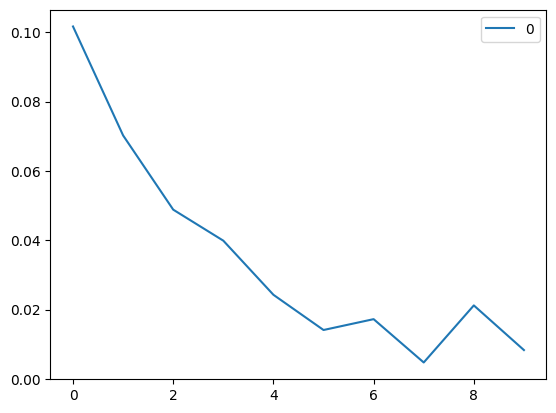

In [28]:

p = params_diff * rain_per_day * 100
p.index = p.index.str.replace('rainfallsince_diff_', '') 
pd.DataFrame(p).plot()

# Appendix - various scratch code

<Axes: xlabel='year_climatic'>

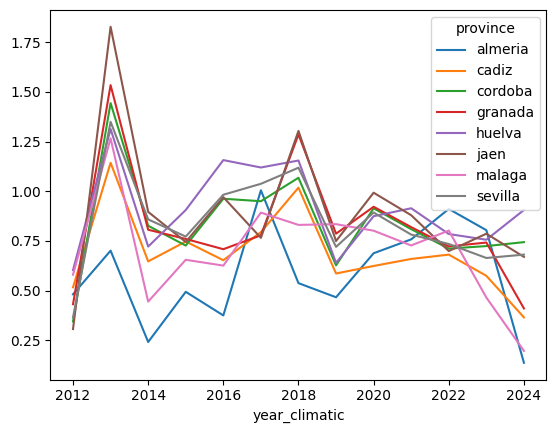

In [32]:
data_yearly.reset_index().groupby(['year_climatic', 'province']).rel_rainfall_compare.mean().unstack().plot()

In [36]:
data_yearly.reset_index().query('province=="malaga"').groupby('year_climatic').rainfallsince.mean()

year_climatic
2012    307.1
2013    646.1
2014    229.7
2015    344.0
2016    322.7
2017    466.4
2018    434.3
2019    421.6
2020    416.7
2021    375.9
2022    405.2
2023    245.8
2024     66.3
Name: rainfallsince, dtype: float64